In [1]:
#importing all the things

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import ast
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
#initializing constants
START_DATE = '10/08/2016'
NUM_OF_WEEKS = 24

In [3]:
def get_file_names(start,number): #generates weeknums
    files = []
    ds = dt.datetime.strptime(start,"%m/%d/%Y")
    file_name = (ds.strftime("%y%m%d"))
    files.append(int(file_name))
    for i in range(1,number+1):
        ds = ds+ dt.timedelta(days=7)
        file_name = int(ds.strftime("%y%m%d"))
        files.append(file_name)
    print (files)
    return files


def get_data_parse_dt(week_nums): #imports files from mta website
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        print("week ",week_num,"added")
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

def sortLinename(string):
    listLines = ''.join(sorted(string))
    return listLines

In [4]:
data = get_data_parse_dt(get_file_names(START_DATE,NUM_OF_WEEKS))
data.head()

[161008, 161015, 161022, 161029, 161105, 161112, 161119, 161126, 161203, 161210, 161217, 161224, 161231, 170107, 170114, 170121, 170128, 170204, 170211, 170218, 170225, 170304, 170311, 170318, 170325]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,10/01/2016,00:00:00,REGULAR,5848880,1982967
1,A002,R051,02-00-00,59 ST,NQR456,BMT,10/01/2016,04:00:00,REGULAR,5848921,1982974
2,A002,R051,02-00-00,59 ST,NQR456,BMT,10/01/2016,08:00:00,REGULAR,5848946,1983017
3,A002,R051,02-00-00,59 ST,NQR456,BMT,10/01/2016,12:00:00,REGULAR,5849068,1983119
4,A002,R051,02-00-00,59 ST,NQR456,BMT,10/01/2016,16:00:00,REGULAR,5849358,1983191


In [5]:
data.columns = [column.strip().lower() for column in data.columns] #formatting
data["date_time"] = pd.to_datetime(data.date + " " + data.time, format="%m/%d/%Y %H:%M:%S") #creating datetime column

In [6]:
data.linename = data.linename.apply(sortLinename) #standardizing linenames

In [7]:
oldline = ((data.station=='86 ST') & (data.linename=='456')) | ((data.station=='96 ST') & (data.linename=='6'))
#print (data[oldline].head())
newline = ((data.station=='86 ST-2 AVE') & (data.linename=='Q')) | ((data.station=='96 ST-2 AVE') & (data.linename=='Q'))
#print (data[newline].head())
control = (((data.station=='103 ST') | (data.station=='110 ST')) & (data.linename=='6'))
#print (data[control].head())
_77th456 = ((data.station=='77 ST') & (data.linename=='6'))

mask = ((oldline | newline | control | _77th456))
ourstations = (data[mask]).copy()

In [8]:
ourstations.date = pd.to_datetime(ourstations.date)

In [9]:
(ourstations
 .groupby(["c/a", "unit", "scp", "station", "date_time", "linename"])
 .entries.count()
 .reset_index()
 .sort_values("entries", ascending=False)).head(5)

,c/a,unit,scp,station,date_time,linename,entries
0,N701,R571,00-00-00,86 ST-2 AVE,2016-12-31 00:00:00,Q,1
49377,R250,R179,00-00-06,86 ST,2017-01-31 23:00:00,456,1
49429,R250,R179,00-00-06,86 ST,2017-02-08 23:00:00,456,1
49428,R250,R179,00-00-06,86 ST,2017-02-08 19:00:00,456,1
49427,R250,R179,00-00-06,86 ST,2017-02-08 15:00:00,456,1


In [10]:
#ourstations = data.drop(["exits", "desc"], axis=1, errors="ignore")

In [11]:
ourstations["date"] = pd.to_datetime(ourstations["date"])

In [12]:
ourstations.sort_values(["c/a", "unit", "scp", "station", "date_time"],
                         inplace=True, ascending=False)

In [13]:
dailyData = (ourstations.groupby(["c/a", "unit", "scp", "station", "date", "linename"],as_index=False)
                        .entries.first())

In [14]:
dailyData[["prev_date", "prev_entries"]] = (dailyData.groupby(["c/a", "unit", "scp", "station", "linename"])
                                            ["date", "entries"].transform(lambda grp: grp.shift(1)))
dailyData.dropna(subset=["prev_date"], axis=0, inplace=True)

In [15]:
dailyData.head()

,c/a,unit,scp,station,date,linename,entries,prev_date,prev_entries
1,N701,R571,00-00-00,86 ST-2 AVE,2017-01-01,Q,2103,2016-12-31,32.0
2,N701,R571,00-00-00,86 ST-2 AVE,2017-01-02,Q,4850,2017-01-01,2103.0
3,N701,R571,00-00-00,86 ST-2 AVE,2017-01-03,Q,8294,2017-01-02,4850.0
4,N701,R571,00-00-00,86 ST-2 AVE,2017-01-04,Q,12193,2017-01-03,8294.0
5,N701,R571,00-00-00,86 ST-2 AVE,2017-01-05,Q,15865,2017-01-04,12193.0


In [16]:
dailyData[dailyData["entries"] < dailyData["prev_entries"]]

,c/a,unit,scp,station,date,linename,entries,prev_date,prev_entries
10797,R252,R180,00-03-00,103 ST,2017-02-26,6,303,2017-02-23,8245866.0


In [17]:
(dailyData
 .groupby(["c/a", "unit", "scp", "station"])['entries'].count()
    .reset_index().sort_values('entries',ascending=True))

,c/a,unit,scp,station,entries
0,N701,R571,00-00-00,86 ST-2 AVE,83
30,N702A,R572,01-03-04,96 ST-2 AVE,83
29,N702A,R572,01-03-03,96 ST-2 AVE,83
27,N702A,R572,01-03-01,96 ST-2 AVE,83
26,N702A,R572,01-03-00,96 ST-2 AVE,83
25,N702A,R572,01-00-04,96 ST-2 AVE,83
24,N702A,R572,01-00-03,96 ST-2 AVE,83
23,N702A,R572,01-00-02,96 ST-2 AVE,83
22,N702A,R572,01-00-01,96 ST-2 AVE,83
21,N702A,R572,01-00-00,96 ST-2 AVE,83


In [18]:
(dailyData
 .groupby(["c/a", "unit", "scp", "station"])['date'].count()
    .reset_index()['date'].value_counts())

174    49
83     31
173     5
172     1
Name: date, dtype: int64

In [19]:
(dailyData[dailyData["entries"] < dailyData["prev_entries"]]
    .groupby(["c/a", "unit", "scp", "station"])
    .size())

c/a   unit  scp       station
R252  R180  00-03-00  103 ST     1
dtype: int64

In [20]:
def get_daily_counts(row, max_counter):
    counter = abs(row["entries"] - row["prev_entries"])
    if counter > max_counter:
        print(row["entries"], row["prev_entries"])
        counter = min(row["entries"], row["prev_entries"])
    if counter > max_counter:
        return 0
    return counter

In [21]:
dailyData["daily_entries"] = dailyData.apply(get_daily_counts, axis=1, max_counter=20000)

303 8245866.0


In [22]:
dailyData[dailyData["daily_entries"]==0]

,c/a,unit,scp,station,date,linename,entries,prev_date,prev_entries,daily_entries
338,N701,R571,00-05-00,86 ST-2 AVE,2017-01-02,Q,36569137,2017-01-01,36569137.0,0.0
343,N701,R571,00-05-00,86 ST-2 AVE,2017-01-07,Q,36569153,2017-01-06,36569153.0,0.0
363,N701,R571,00-05-00,86 ST-2 AVE,2017-01-27,Q,36569200,2017-01-26,36569200.0,0.0
366,N701,R571,00-05-00,86 ST-2 AVE,2017-01-30,Q,36569204,2017-01-29,36569204.0,0.0
379,N701,R571,00-05-00,86 ST-2 AVE,2017-02-12,Q,36569230,2017-02-11,36569230.0,0.0
395,N701,R571,00-05-00,86 ST-2 AVE,2017-02-28,Q,36569255,2017-02-27,36569255.0,0.0
396,N701,R571,00-05-00,86 ST-2 AVE,2017-03-01,Q,36569255,2017-02-28,36569255.0,0.0
399,N701,R571,00-05-00,86 ST-2 AVE,2017-03-04,Q,36569259,2017-03-03,36569259.0,0.0
402,N701,R571,00-05-00,86 ST-2 AVE,2017-03-07,Q,36569261,2017-03-06,36569261.0,0.0
404,N701,R571,00-05-00,86 ST-2 AVE,2017-03-09,Q,36569264,2017-03-08,36569264.0,0.0


In [23]:
dailyStations = pd.DataFrame((dailyData
    .groupby(["station", "date", "linename"])['daily_entries'].sum().reset_index()))
dailyStations[dailyStations.station=='103 ST'].head(7)['daily_entries'].sum()

95029.0

In [24]:
(dailyStations.groupby(['station', 'linename', pd.Grouper(key='date', freq='W-SAT')])['daily_entries']
       .sum()
       .reset_index()
       .sort_values('date'))

,station,linename,date,daily_entries
0,103 ST,6,2016-10-08,95029.0
75,86 ST,456,2016-10-08,397692.0
50,77 ST,6,2016-10-08,209107.0
25,110 ST,6,2016-10-08,80434.0
112,96 ST,6,2016-10-08,153800.0
76,86 ST,456,2016-10-15,389420.0
26,110 ST,6,2016-10-15,77887.0
51,77 ST,6,2016-10-15,208267.0
1,103 ST,6,2016-10-15,93946.0
113,96 ST,6,2016-10-15,149819.0


In [25]:
df = pd.DataFrame(dailyStations.pivot(index='date', columns='station')['daily_entries'])

In [26]:
df.columns

Index(['103 ST', '110 ST', '77 ST', '86 ST', '86 ST-2 AVE', '96 ST',
       '96 ST-2 AVE'],
      dtype='object', name='station')

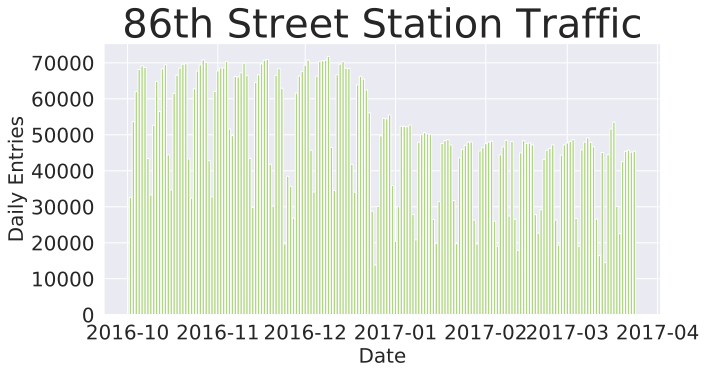

In [27]:
plt.figure(figsize = [10,5])
p1=plt.bar(df.index,df['86 ST'], color='#AED581')
#p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic", fontsize='40');

#plt.legend('456 Station',loc='center left', bbox_to_anchor=(1, 0.5));

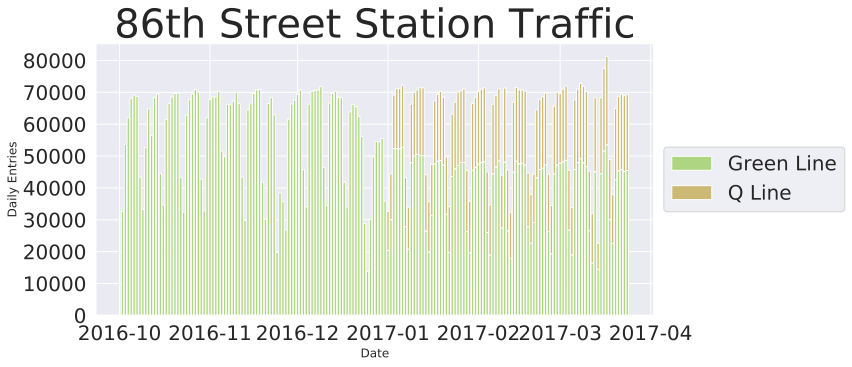

In [28]:
plt.figure(figsize = [10,5])
p1 = plt.bar(df.index,df['86 ST'], color='#AED581')
p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date')
plt.ylabel('Daily Entries')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic", fontsize='40')


plt.legend((p1[0],p2[0]),('Green Line','Q Line'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

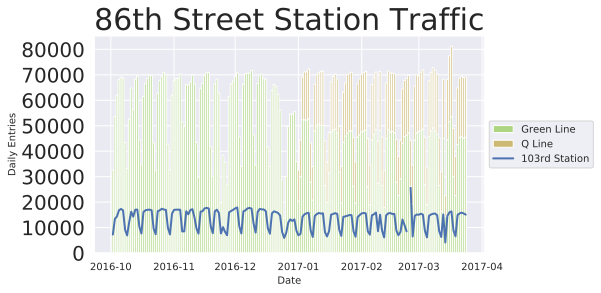

In [30]:
plt.figure(figsize = [7,4])
p1 = plt.bar(df.index,df['86 ST'], color='#AED581')
p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
p3 = plt.plot(df.index,df['103 ST'],color='b', linewidth='2')
plt.xlabel('Date', fontsize='10')
plt.ylabel('Daily Entries', fontsize='10')
plt.xticks(fontsize='10')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic",fontsize='30')


plt.legend((p1[0],p2[0],p3[0]),('Green Line','Q Line','103rd Station'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='10');

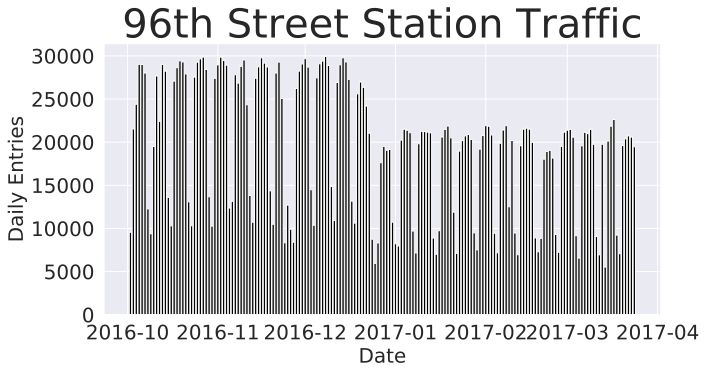

In [31]:
plt.figure(figsize = [10,5])
p1=plt.bar(df.index,df['96 ST'], color='black')
#p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic", fontsize='40');

#plt.legend('456 Station',loc='center left', bbox_to_anchor=(1, 0.5));

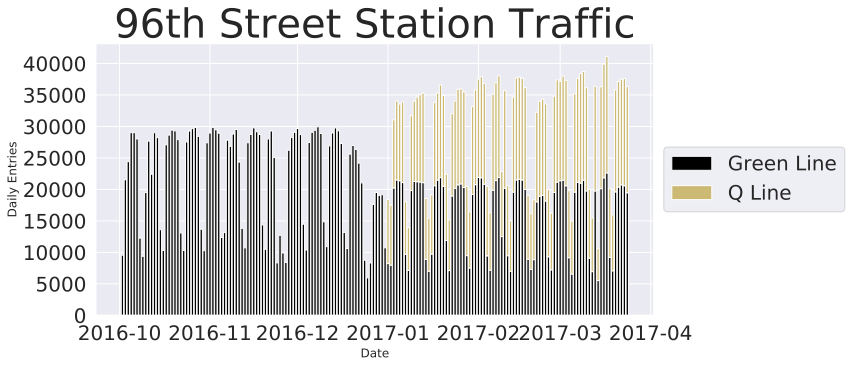

In [32]:
plt.figure(figsize = [10,5])
p1 = plt.bar(df.index,df['96 ST'], color='black')
p2 = plt.bar(df.index,df['96 ST-2 AVE'], bottom=df['96 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date')
plt.ylabel('Daily Entries')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic", fontsize='40')


plt.legend((p1[0],p2[0]),('Green Line','Q Line'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

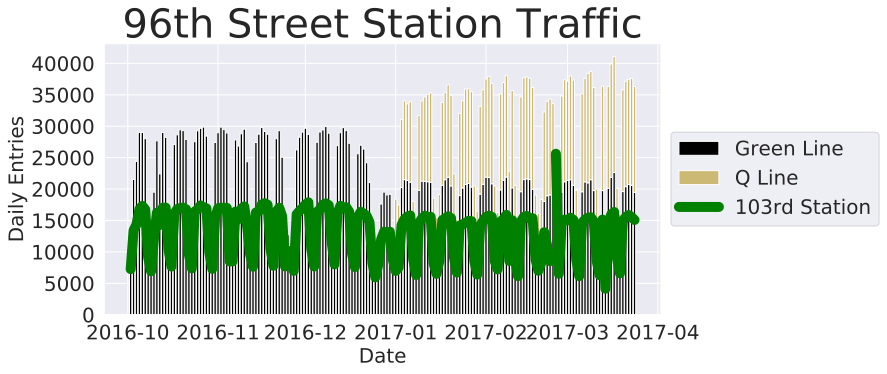

In [33]:
plt.figure(figsize = [10,5])
p1 = plt.bar(df.index,df['96 ST'], color='black')
p2 = plt.bar(df.index,df['96 ST-2 AVE'], bottom=df['96 ST'],color='y')
p3 = plt.plot(df.index,df['103 ST'],color='green',linewidth='10')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic",fontsize='40')


plt.legend((p1[0],p2[0],p3[0]),('Green Line','Q Line','103rd Station'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

# Weekly Graphs Now

In [34]:
df_weekly=pd.DataFrame(dailyStations.groupby(['station', 'linename', pd.Grouper(key='date', freq='W-SAT')])['daily_entries']
       .sum()
       .reset_index()
       .sort_values('date'))

In [35]:
weeklypivot = pd.DataFrame(df_weekly.pivot(index='date', columns='station')['daily_entries'])

In [36]:
weeklypivot

station,103 ST,110 ST,77 ST,86 ST,86 ST-2 AVE,96 ST,96 ST-2 AVE
date,,,,,,,
2016-10-08,95029.0,80434.0,209107.0,397692.0,NaN,153800.0,NaN
2016-10-15,93946.0,77887.0,208267.0,389420.0,NaN,149819.0,NaN
2016-10-22,100921.0,83783.0,227829.0,413920.0,NaN,165739.0,NaN
2016-10-29,101871.0,83614.0,233532.0,416055.0,NaN,168744.0,NaN
2016-11-05,99250.0,82908.0,226593.0,421672.0,NaN,167238.0,NaN
2016-11-12,97867.0,81630.0,228189.0,429040.0,NaN,164288.0,NaN
2016-11-19,103644.0,83203.0,232501.0,414263.0,NaN,168883.0,NaN
2016-11-26,83082.0,67808.0,177924.0,321860.0,NaN,123797.0,NaN
2016-12-03,102374.0,81440.0,228471.0,408097.0,NaN,164799.0,NaN


In [51]:
%config InlineBackend.figure_format = 'svg'

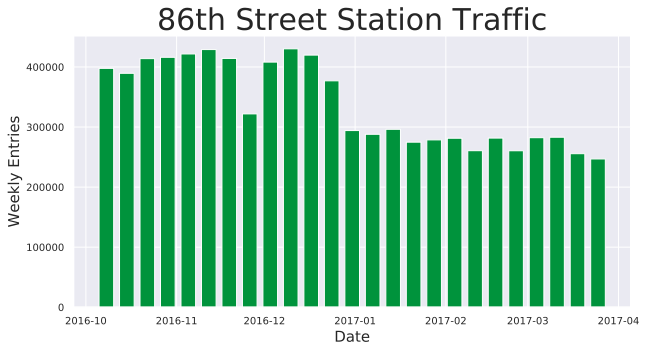

In [132]:
plt.figure(figsize = [10,5])
p1=plt.bar(weeklypivot.index,weeklypivot['86 ST'], color='#00933C',width=5)
#p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize='15')
plt.ylabel('Weekly Entries', fontsize='15')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title("86th Street Station Traffic", fontsize='30')
plt.savefig('graphs/86th_bar.png',bbox_inches='tight');

#plt.legend('456 Station',loc='center left', bbox_to_anchor=(1, 0.5));

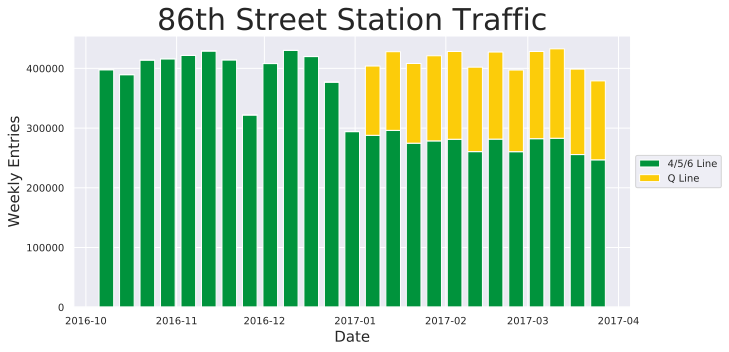

In [121]:
plt.figure(figsize = [10,5])
p1 = plt.bar(weeklypivot.index,weeklypivot['86 ST'], color='#00933C',width=5)
p2 = plt.bar(weeklypivot.index,weeklypivot['86 ST-2 AVE'], bottom=weeklypivot['86 ST'],color='#FCCC0A',width=5)
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Weekly Entries', fontsize=15)
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title("86th Street Station Traffic", fontsize='30')


plt.legend((p1[0],p2[0]),('4/5/6 Line','Q Line'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='10')
plt.savefig('graphs/86th_stack_bar.png',bbox_inches='tight');

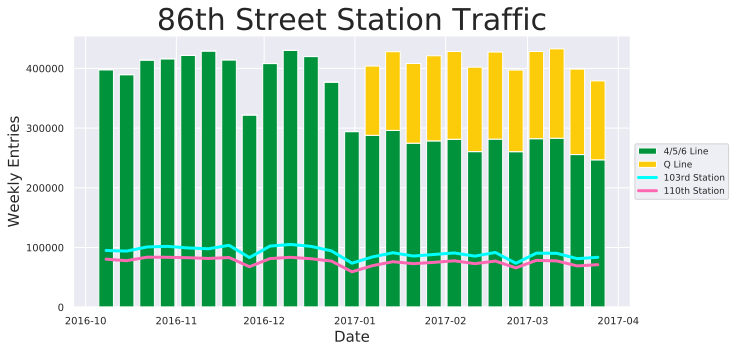

In [122]:
plt.figure(figsize = [10,5])
p1 = plt.bar(weeklypivot.index,weeklypivot['86 ST'], color='#00933C',width=5)
p2 = plt.bar(weeklypivot.index,weeklypivot['86 ST-2 AVE'], bottom=weeklypivot['86 ST'],color='#FCCC0A',width=5)
p3 = plt.plot(weeklypivot.index,weeklypivot['103 ST'],color='#00ffff', linewidth=3)
p4 = plt.plot(weeklypivot.index,weeklypivot['110 ST'],color='#ff69b4', linewidth=3) #, linestyle='dotted')

plt.xlabel('Date', fontsize='15')
plt.ylabel('Weekly Entries', fontsize='15')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title("86th Street Station Traffic",fontsize='30')


plt.legend((p1[0],p2[0],p3[0],p4[0]),('4/5/6 Line','Q Line','103rd Station','110th Station'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='9')
plt.savefig('graphs/86th_stack_bar_plus_control.png',bbox_inches='tight');

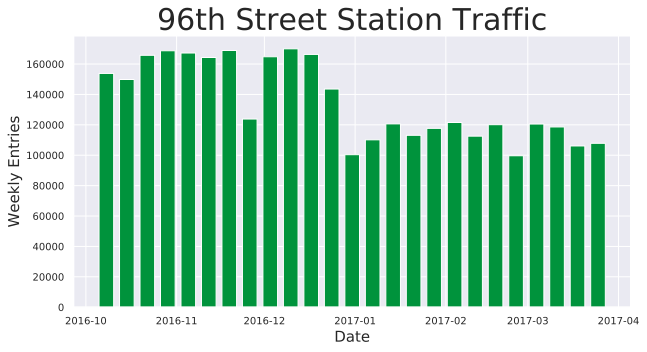

In [123]:
plt.figure(figsize = [10,5])
p1=plt.bar(weeklypivot.index,weeklypivot['96 ST'], color='#00933C',width=5)
#p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize='15')
plt.ylabel('Weekly Entries', fontsize='15')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title("96th Street Station Traffic", fontsize='30')

plt.savefig('graphs/96th_bar.png',bbox_inches='tight');

#plt.legend('456 Station',loc='center left', bbox_to_anchor=(1, 0.5));

''

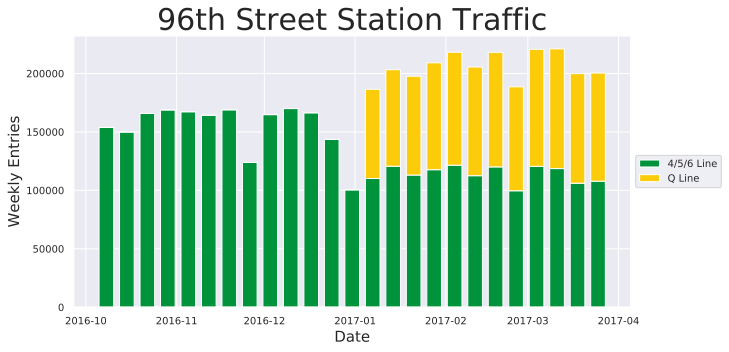

In [124]:
plt.figure(figsize = [10,5])
p1 = plt.bar(weeklypivot.index,weeklypivot['96 ST'], color='#00933C',width=5)
p2 = plt.bar(weeklypivot.index,weeklypivot['96 ST-2 AVE'], bottom=weeklypivot['96 ST'],color='#FCCC0A',width=5)
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Weekly Entries', fontsize=15)
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title("96th Street Station Traffic", fontsize='30')


plt.legend((p1[0],p2[0]),('4/5/6 Line','Q Line'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='10')
plt.savefig('graphs/96th_stack_bar.png',bbox_inches='tight')
;

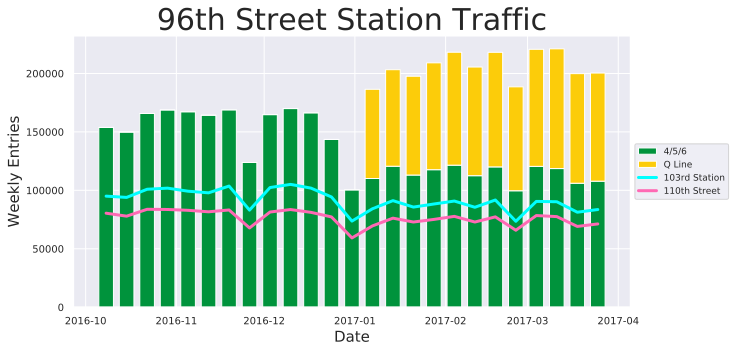

In [125]:
plt.figure(figsize = [10,5])
p1 = plt.bar(weeklypivot.index,weeklypivot['96 ST'], color='#00933C',width=5)
p2 = plt.bar(weeklypivot.index,weeklypivot['96 ST-2 AVE'], bottom=weeklypivot['96 ST'],color='#FCCC0A',width=5)
p3 = plt.plot(weeklypivot.index,weeklypivot['103 ST'],color='#00ffff', linewidth=3)
p4 = plt.plot(weeklypivot.index,weeklypivot['110 ST'],color='#ff69b4', linewidth=3) #, linestyle='dotted')

plt.xlabel('Date', fontsize='15')
plt.ylabel('Weekly Entries', fontsize='15')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title("96th Street Station Traffic",fontsize='30')


plt.legend((p1[0],p2[0],p3[0],p4[0]),('4/5/6','Q Line','103rd Station','110th Street'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='9')

plt.savefig('graphs/96th_stack_bar_plus_control.png',bbox_inches='tight');


In [126]:
weeklypivot=weeklypivot.fillna(0)
weeklypivot['total_86']=weeklypivot['86 ST'] + weeklypivot['86 ST-2 AVE']
weeklypivot['total_96']=weeklypivot['96 ST'] + weeklypivot['96 ST-2 AVE']

In [127]:
weeklypivot

station,103 ST,110 ST,77 ST,86 ST,86 ST-2 AVE,96 ST,96 ST-2 AVE,total_86,total_96,103rd_Change,110rd_Change,86th_Change,96th_Change
date,,,,,,,,,,,,,
2016-10-08,95029.0,80434.0,209107.0,397692.0,0.0,153800.0,0.0,397692.0,153800.0,0.000000,0.000000,0.000000,0.000000
2016-10-15,93946.0,77887.0,208267.0,389420.0,0.0,149819.0,0.0,389420.0,149819.0,-0.011397,-0.031666,-0.020800,-0.025884
2016-10-22,100921.0,83783.0,227829.0,413920.0,0.0,165739.0,0.0,413920.0,165739.0,0.062002,0.041637,0.040805,0.077627
2016-10-29,101871.0,83614.0,233532.0,416055.0,0.0,168744.0,0.0,416055.0,168744.0,0.071999,0.039536,0.046174,0.097165
2016-11-05,99250.0,82908.0,226593.0,421672.0,0.0,167238.0,0.0,421672.0,167238.0,0.044418,0.030758,0.060298,0.087373
2016-11-12,97867.0,81630.0,228189.0,429040.0,0.0,164288.0,0.0,429040.0,164288.0,0.029865,0.014869,0.078825,0.068192
2016-11-19,103644.0,83203.0,232501.0,414263.0,0.0,168883.0,0.0,414263.0,168883.0,0.090657,0.034426,0.041668,0.098069
2016-11-26,83082.0,67808.0,177924.0,321860.0,0.0,123797.0,0.0,321860.0,123797.0,-0.125720,-0.156973,-0.190680,-0.195078
2016-12-03,102374.0,81440.0,228471.0,408097.0,0.0,164799.0,0.0,408097.0,164799.0,0.077292,0.012507,0.026163,0.071515


In [128]:
Constant103 = weeklypivot['103 ST'][0]
Constant86 = weeklypivot['total_86'][0]
Constant96 = weeklypivot['total_96'][0]
Constant110 = weeklypivot['110 ST'][0]
weeklypivot['103rd_Change'] = (weeklypivot['103 ST']/Constant103)-1
weeklypivot['110rd_Change'] = (weeklypivot['110 ST']/Constant110)-1
weeklypivot['86th_Change'] = (weeklypivot['total_86']/Constant86)-1
weeklypivot['96th_Change'] = (weeklypivot['total_96']/Constant96)-1


In [129]:
weeklypivot

station,103 ST,110 ST,77 ST,86 ST,86 ST-2 AVE,96 ST,96 ST-2 AVE,total_86,total_96,103rd_Change,110rd_Change,86th_Change,96th_Change
date,,,,,,,,,,,,,
2016-10-08,95029.0,80434.0,209107.0,397692.0,0.0,153800.0,0.0,397692.0,153800.0,0.000000,0.000000,0.000000,0.000000
2016-10-15,93946.0,77887.0,208267.0,389420.0,0.0,149819.0,0.0,389420.0,149819.0,-0.011397,-0.031666,-0.020800,-0.025884
2016-10-22,100921.0,83783.0,227829.0,413920.0,0.0,165739.0,0.0,413920.0,165739.0,0.062002,0.041637,0.040805,0.077627
2016-10-29,101871.0,83614.0,233532.0,416055.0,0.0,168744.0,0.0,416055.0,168744.0,0.071999,0.039536,0.046174,0.097165
2016-11-05,99250.0,82908.0,226593.0,421672.0,0.0,167238.0,0.0,421672.0,167238.0,0.044418,0.030758,0.060298,0.087373
2016-11-12,97867.0,81630.0,228189.0,429040.0,0.0,164288.0,0.0,429040.0,164288.0,0.029865,0.014869,0.078825,0.068192
2016-11-19,103644.0,83203.0,232501.0,414263.0,0.0,168883.0,0.0,414263.0,168883.0,0.090657,0.034426,0.041668,0.098069
2016-11-26,83082.0,67808.0,177924.0,321860.0,0.0,123797.0,0.0,321860.0,123797.0,-0.125720,-0.156973,-0.190680,-0.195078
2016-12-03,102374.0,81440.0,228471.0,408097.0,0.0,164799.0,0.0,408097.0,164799.0,0.077292,0.012507,0.026163,0.071515


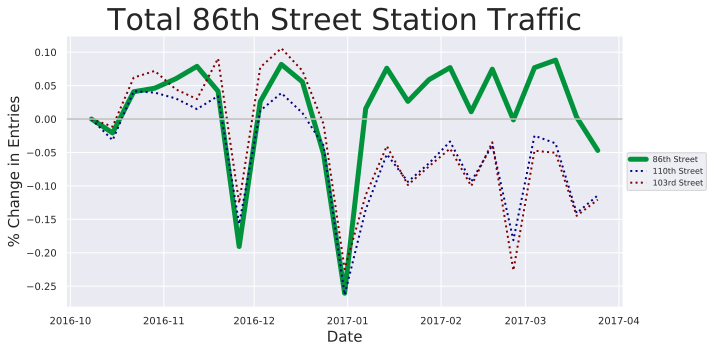

In [130]:
plt.figure(figsize = [10,5])
p1 = plt.plot(weeklypivot.index,weeklypivot['86th_Change'], color='#00933C',linewidth=5)
p2 = plt.plot(weeklypivot.index,weeklypivot['110rd_Change'], color='#000080',linewidth=2, linestyle='dotted')
p3 = plt.plot(weeklypivot.index,weeklypivot['103rd_Change'], color='#800000', linewidth=2, linestyle='dotted')
#plt.grid(which='major', axis='x', color = 'black')
plt.axhline(y=0, color = '#bebebe')
plt.xlabel('Date', fontsize='15')
plt.ylabel('% Change in Entries', fontsize='15')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title("Total 86th Street Station Traffic",fontsize='30')


plt.legend((p1[0],p2[0],p3[0]),('86th Street','110th Street','103rd Street'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='8')
plt.savefig('graphs/86th_perc_change.png',bbox_inches='tight');

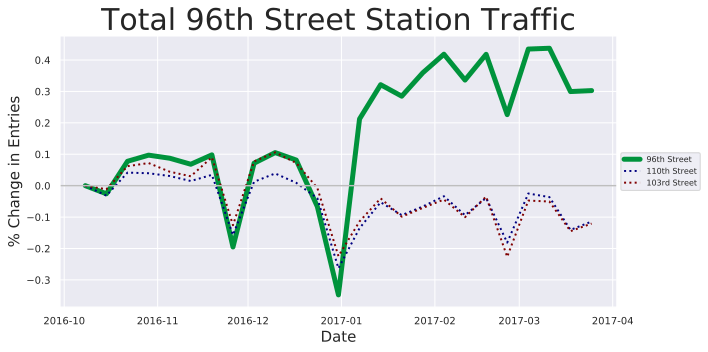

In [131]:
plt.figure(figsize = [10,5])
p1 = plt.plot(weeklypivot.index,weeklypivot['96th_Change'], color='#00933C',linewidth=5)
p2 = plt.plot(weeklypivot.index,weeklypivot['110rd_Change'], color='#000080',linewidth=2, linestyle='dotted')
p3 = plt.plot(weeklypivot.index,weeklypivot['103rd_Change'], color='#800000',linewidth=2, linestyle='dotted')
#p3 = plt.plot(weeklypivot.index,weeklypivot['103 ST'],color='b', linewidth='10')
plt.axhline(y=0, color = '#bebebe')
plt.xlabel('Date', fontsize='15')
plt.ylabel('% Change in Entries', fontsize='15')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.title("Total 96th Street Station Traffic",fontsize='30')

#plt.tight_layout()
plt.legend((p1[0],p2[0],p3[0]),('96th Street','110th Street','103rd Street'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='8')
plt.savefig('graphs/96th_perc_change.png', bbox_inches='tight');